### Imports

In [2]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import statsmodels
from statsmodels.formula.api import ols

import sqlite3 
import json
import folium 
import folium.plugins as plugins
import branca.colormap as cm

%matplotlib inline

import pickle




### Functions

In [3]:
def clean_df(df, 
            bedrooms_min=0, 
            bedrooms_max=100, 
            condition_min = 0, 
            condition_max = 10, 
            grade_min = 0, 
            grade_max = 20, 
            house_age_min = 0, 
            house_age_max = 300, 
            price_min = 0, 
            price_max = 7700000):
    """
    Cleans the dataframe with specified conditions.

    df - dataframe that will be altered
    bedrooms_min - Minimum bedrooms, set to 2 as default
    bedrooms_max - Maximum bedrooms, set to 3 as default
    condition_min - Minimum condition of a home, set to 1 (Fair) by default
    condition_max - Maximum condition of a home, set to 4 (Very Good) by default
    grade_min - Minimum grade for a home, set to 5 (Fair) by default
    grade_max - Maximum grade for a home, set to 11 (Excellent) by default
    house_age_min - Minimum age for a home, set to 0 by default
    house_age_max - Maximum age for a home, set to 300 by default 
    price_min - Minimum price for a home, set to 0 by default 
    price_max - Maximum price for a home, set to 7700000 by default
    
    """

    # Creating a copy of df and creating for future data shaping.
    df_copy = df.copy()
    drop_columns = ['waterfront', 'view', 'sqft_basement','sqft_lot','sqft_lot15']
    condition_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}

    # Dropping unnecessary columns and removing a 
   # df_copy.drop(drop_columns, axis= 1, inplace=True)
    df_copy = df_copy[df_copy['bedrooms']!=33]
    
    df_copy['date'] = pd.to_datetime(df_copy["date"])
    
    df_copy['grade_value'] = df_copy['grade'].map(lambda x: x[:2])
    df_copy['grade_value'] = df_copy['grade_value'].astype(int)

    df_copy['age'] = df_copy['yr_built']
    df_copy.loc[df_copy['yr_renovated'] != 0, 'age'] = df_copy['yr_renovated']
    df_copy['age'] = df_copy['age'].map(lambda x: 2015-x)

    df_copy['condition_num'] = df_copy['condition'].map(condition_dict)

    df_copy = df_copy[df_copy['bedrooms'] >= bedrooms_min]
    df_copy = df_copy[df_copy['bedrooms'] <= bedrooms_max]

    df_copy = df_copy[df_copy['condition_num'] >= condition_min]
    df_copy = df_copy[df_copy['condition_num'] <= condition_max]

    df_copy = df_copy[df_copy['grade_value'] >= grade_min]
    df_copy = df_copy[df_copy['grade_value'] <= grade_max]

    df_copy = df_copy[df_copy['age'] >= house_age_min]
    df_copy = df_copy[df_copy['age'] <= house_age_max]

    df_copy = df_copy[df_copy['price'] >= price_min]
    df_copy = df_copy[df_copy['price'] <= price_max]

    df_clean = df_copy.copy()

    return(df_clean)

def map_feature_by_zipcode(zipcode_data, col):
    """
    Generates a folium map of Seattle
    :param zipcode_data: zipcode dataset
    :param col: feature to display
    :return: m
    """

    # read updated geo data
    king_geo = "cleaned_geodata.json"

    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[47.35, -121.9], zoom_start=9.25,
                   detect_retina=True, control_scale=False, tiles='OpenStreetMap')

    # Create choropleth map
    m.choropleth(
        geo_data=king_geo,
        name='choropleth',
        data=zipcode_data,
        # col: feature of interest
        columns=['zipcode', col],
        key_on='feature.properties.ZIPCODE',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='house ' + col
    )
    folium.LayerControl().add_to(m)

    # Save map based on feature of interest
    m.save(col + '.html')

    return m

def train_lr_randomly(data, sample_pt=None, ntimes=100):
    '''
    Takes in features & targets from `data` to train a linear regression with a
    random sample `ntimes`. It then returns a list of R2 scores, RMSEs, and the 
    predictions from a provided data point of features `sample_pt`.
    '''
    # To save all of our predictions
    r2 = []
    rmse = []
    # Only return predictions if there is something to predict (sample_pt given)
    point_preds = [] if (sample_pt is not None) else None

    # We'll repeat this little experiment to see how the model does
    for i in range(ntimes):
        # Creating a random sample of data to train on
        df_sample = data.sample(5000, replace=True)
        y = df_sample.price
        X = df_sample.drop('price', axis=1)

        # Our linear regression model about to be trained
        lr = LinearRegression()
        lr.fit(X, y)

        # Making predictions & evaluating on the data we used to train the model
        y_hat = lr.predict(X)
        rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
        r2.append(lr.score(X, y))

        # Making a prediction on the one point the model definitely never saw
        if sample_pt is not None:
            y_hat_pt = lr.predict(sample_pt)
            # Getting just the single point to add into list
            point_preds.append(y_hat_pt[0])
    
    return r2, rmse, point_preds



### Data Preparation

In [4]:
df = pd.read_csv('./data/kc_house_data.csv')

In [5]:
df = clean_df(df)
df.duplicated(subset='id').sum()
df = df.drop_duplicates(subset="id",keep="last")

In [6]:
variables = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 'floors', 'sqft_above', 'lat', 'long', 'grade_value', 'age', 'condition_num']
price_var = ['price'] + variables

In [7]:
df['price_log'] = df['price'].map(lambda x: np.log(x))

In [8]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'grade_value', 'age',
       'condition_num', 'price_log'],
      dtype='object')

### Simple Model

picking out variables that seemed to have high significance at first glance

In [9]:
r2_dict = {}
rmse_dict = {}

In [10]:
y1 = df['price']
x1 = df[['bedrooms','bathrooms','sqft_living','grade_value']]
X1 = sm.add_constant(x1)
model1 = sm.OLS(y1,X1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     5227.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:20:26   Log-Likelihood:            -2.4426e+05
No. Observations:               17639   AIC:                         4.885e+05
Df Residuals:                   17634   BIC:                         4.886e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -4.5e+05   1.69e+04    -26.614      0.000   -4.83e+05   -4.17e+05
bedrooms    -4.501e+04   2673.180    -16.837      0.000   -5.02e+04   -3.98e+04
bathrooms   -2.376e+04   3891.555     -6.106      0.000   -3.14e+04   -1.61e+04
sqft_living   234.9059      4.029     58.306      0.000     227.009     242.803
grade_value  9.188e+04   2605.556     35.262      0.000    8.68e+04     9.7e+04
==============================================================================
Omnibus:                    13782.754   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           818935.134
Skew:                           3.273   Prob(JB):                         0.00
Kurtosis:                      35.732   Cond. No.                     2.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, 
                                                    y1,
                                                    test_size=None,
                                                    random_state=42)

In [12]:
lr1 = LinearRegression()
lr1.fit(X_train1, y_train1)

LinearRegression()

In [13]:
r2_1 = lr1.score(X_test1, y_test1)

In [54]:
rmse1 = (sum((y_test1 - lr1.predict(X_test1))**2)/len(y_test1))**.5
rmse_per1 = rmse1/(df['price'].sum()/len(df['price']))
rmse_per1

0.47774162291718275

In [55]:
r2_dict['Simple Model'] = r2_1
rmse_dict['Simple Model'] = rmse_per1

r2_dict, rmse_dict

({'Simple Model': 0.5403161972789886,
  'Poly Model': 0.6024545699824639,
  'Simple Comprehensive Model': 0.627714295542342,
  'Poly Comprehensive Model': 0.7520144875062552,
  'Simple Comprehensive Logged Model': 0.7398550742334893,
  'Poly Comprehensive Logged Model': 0.7896678764548601},
 {'Simple Model': 0.47774162291718275,
  'Poly Model': 243334.7061850583,
  'Simple Comprehensive Model': 232942.96539019627,
  'Poly Comprehensive Model': 192186.9204408737,
  'Simple Comprehensive Logged Model': 0.26634108301095594,
  'Poly Comprehensive Logged Model': 0.23932696197458758})

### Poly Model

In [16]:
df_pol2 = df[['bedrooms','bathrooms','sqft_living','grade_value']]
poly_2 = PolynomialFeatures(2)

X_poly2 = pd.DataFrame(
            poly_2.fit_transform(df_pol2)
                      )

y2 = df.price
X_poly2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,3.0,1.00,1180.0,7.0,9.0,3.00,3540.0,21.0,1.0000,1180.0,7.00,1392400.0,8260.0,49.0
1,1.0,3.0,2.25,2570.0,7.0,9.0,6.75,7710.0,21.0,5.0625,5782.5,15.75,6604900.0,17990.0,49.0
2,1.0,4.0,3.00,1960.0,7.0,16.0,12.00,7840.0,28.0,9.0000,5880.0,21.00,3841600.0,13720.0,49.0
3,1.0,3.0,2.00,1680.0,8.0,9.0,6.00,5040.0,24.0,4.0000,3360.0,16.00,2822400.0,13440.0,64.0
4,1.0,4.0,4.50,5420.0,11.0,16.0,18.00,21680.0,44.0,20.2500,24390.0,49.50,29376400.0,59620.0,121.0


In [17]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_poly2, y2,
                                                    test_size=0.2,
                                                    random_state=42)
lr_poly2 = LinearRegression()

# Always fit on the training set
lr_poly2.fit(X_train2, y_train2)

r2_2 = lr_poly2.score(X_test2, y_test2)
r2_2

0.6024545699824639

In [56]:
rmse2 = (sum((y_test2 - lr_poly2.predict(X_test2))**2)/len(y_test2))**.5
rmse_per2 = rmse2/(df['price'].sum()/len(df['price']))
rmse_per2

0.44911350604033307

In [57]:
r2_dict['Poly Model'] = r2_2
rmse_dict['Poly Model'] = rmse_per2

r2_dict, rmse_dict

({'Simple Model': 0.5403161972789886,
  'Poly Model': 0.6024545699824639,
  'Simple Comprehensive Model': 0.627714295542342,
  'Poly Comprehensive Model': 0.7520144875062552,
  'Simple Comprehensive Logged Model': 0.7398550742334893,
  'Poly Comprehensive Logged Model': 0.7896678764548601},
 {'Simple Model': 0.47774162291718275,
  'Poly Model': 0.44911350604033307,
  'Simple Comprehensive Model': 232942.96539019627,
  'Poly Comprehensive Model': 192186.9204408737,
  'Simple Comprehensive Logged Model': 0.26634108301095594,
  'Poly Comprehensive Logged Model': 0.23932696197458758})

### Simple Comprehensive Model

In [20]:
y3 = df['price']
x3 = df[variables]
X3 = sm.add_constant(x3)
model3 = sm.OLS(y3,X3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     2899.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:20:28   Log-Likelihood:            -2.4205e+05
No. Observations:               17639   AIC:                         4.841e+05
Df Residuals:                   17627   BIC:                         4.842e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.634e+07   1.77e+06    -31.760      0.000   -5.98e+07   -5.29e+07
bedrooms      -5.045e+04   2370.343    -21.283      0.000   -5.51e+04   -4.58e+04
bathrooms      4.445e+04   3961.023     11.223      0.000    3.67e+04    5.22e+04
sqft_living     193.3539      5.195     37.221      0.000     183.172     203.536
sqft_living15    36.8658      4.128      8.930      0.000      28.774      44.957
floors        -5230.0395   4334.303     -1.207      0.228   -1.37e+04    3265.622
sqft_above       12.5491      5.187      2.419      0.016       2.383      22.716
lat            5.484e+05   1.26e+04     43.574      0.000    5.24e+05    5.73e+05
long          -2.414e+05   1.39e+04    -17.347      0.000   -2.69e+05   -2.14e+05
grade_value    9.347e+04   2622.070     35.647      0.000    8.83e+04    9.86e+04
age            2202.9633     85.674     25.713      0.000    2035.034    2370.893
condition_num  3.191e+04   2848.095     11.205      0.000    2.63e+04    3.75e+04
==============================================================================
Omnibus:                    16200.594   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1691684.659
Skew:                           4.056   Prob(JB):                         0.00
Kurtosis:                      50.286   Cond. No.                     3.89e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, 
                                                    y3,
                                                    test_size=None,
                                                    random_state=42)

In [22]:
lr3 = LinearRegression()
lr3.fit(X_train3, y_train3)

LinearRegression()

In [23]:
r2_3 = lr3.score(X_test3, y_test3)

In [58]:
rmse3 = (sum((y_test3 - lr3.predict(X_test3))**2)/len(y_test3))**.5
rmse_per3 = rmse3/(df['price'].sum()/len(df['price']))
rmse_per3

0.42993386982891035

In [59]:
r2_dict['Simple Comprehensive Model'] = r2_3
rmse_dict['Simple Comprehensive Model'] = rmse_per3

r2_dict, rmse_dict

({'Simple Model': 0.5403161972789886,
  'Poly Model': 0.6024545699824639,
  'Simple Comprehensive Model': 0.627714295542342,
  'Poly Comprehensive Model': 0.7520144875062552,
  'Simple Comprehensive Logged Model': 0.7398550742334893,
  'Poly Comprehensive Logged Model': 0.7896678764548601},
 {'Simple Model': 0.47774162291718275,
  'Poly Model': 0.44911350604033307,
  'Simple Comprehensive Model': 0.42993386982891035,
  'Poly Comprehensive Model': 192186.9204408737,
  'Simple Comprehensive Logged Model': 0.26634108301095594,
  'Poly Comprehensive Logged Model': 0.23932696197458758})

### Poly Comprehensive Model

In [26]:
df_pol4 = df[variables]
poly_4 = PolynomialFeatures(2)

X_poly4 = pd.DataFrame(
            poly_4.fit_transform(df_pol4)
                      )

y4 = df.price
X_poly4.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,1.0,3.0,1.00,1180.0,1340.0,1.0,1180.0,47.5112,-122.257,7.0,...,14946.774049,-855.799,-7335.420,-244.514,49.0,420.0,14.0,3600.0,120.0,4.0
1,1.0,3.0,2.25,2570.0,1690.0,2.0,2170.0,47.7210,-122.319,7.0,...,14961.937761,-856.233,-2935.656,-244.638,49.0,168.0,14.0,576.0,48.0,4.0
2,1.0,4.0,3.00,1960.0,1360.0,1.0,1050.0,47.5208,-122.393,7.0,...,14980.046449,-856.751,-6119.650,-489.572,49.0,350.0,28.0,2500.0,200.0,16.0
3,1.0,3.0,2.00,1680.0,1800.0,1.0,1680.0,47.6168,-122.045,8.0,...,14894.982025,-976.360,-3417.260,-244.090,64.0,224.0,16.0,784.0,56.0,4.0
4,1.0,4.0,4.50,5420.0,4760.0,1.0,3890.0,47.6561,-122.005,11.0,...,14885.220025,-1342.055,-1708.070,-244.010,121.0,154.0,22.0,196.0,28.0,4.0


In [27]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_poly4, y4,
                                                    test_size=0.2,
                                                    random_state=42)
lr_poly4 = LinearRegression()

# Always fit on the training set
lr_poly4.fit(X_train4, y_train4)

r2_4 = lr_poly4.score(X_test4, y_test4)
r2_4

0.7520144875062552

In [60]:
rmse4 = (sum((y_test4 - lr_poly4.predict(X_test4))**2)/len(y_test4))**.5
rmse_per4 = rmse4/(df['price'].sum()/len(df['price']))
rmse_per4

0.35471200556427385

In [61]:
r2_dict['Poly Comprehensive Model'] = r2_4
rmse_dict['Poly Comprehensive Model'] = rmse_per4
r2_dict, rmse_dict

({'Simple Model': 0.5403161972789886,
  'Poly Model': 0.6024545699824639,
  'Simple Comprehensive Model': 0.627714295542342,
  'Poly Comprehensive Model': 0.7520144875062552,
  'Simple Comprehensive Logged Model': 0.7398550742334893,
  'Poly Comprehensive Logged Model': 0.7896678764548601},
 {'Simple Model': 0.47774162291718275,
  'Poly Model': 0.44911350604033307,
  'Simple Comprehensive Model': 0.42993386982891035,
  'Poly Comprehensive Model': 0.35471200556427385,
  'Simple Comprehensive Logged Model': 0.26634108301095594,
  'Poly Comprehensive Logged Model': 0.23932696197458758})

### Simple Comprehensive Logged Model

In [30]:
y5 = df['price_log']
x5 = df[variables]
X5 = sm.add_constant(x5)
model5 = sm.OLS(y5,X5).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     4625.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:20:32   Log-Likelihood:                -1650.8
No. Observations:               17639   AIC:                             3326.
Df Residuals:                   17627   BIC:                             3419.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -72.5916      2.138    -33.950      0.000     -76.783     -68.401
bedrooms         -0.0252      0.003     -8.821      0.000      -0.031      -0.020
bathrooms         0.0673      0.005     14.104      0.000       0.058       0.077
sqft_living       0.0002   6.26e-06     31.780      0.000       0.000       0.000
sqft_living15     0.0001   4.98e-06     23.157      0.000       0.000       0.000
floors            0.0560      0.005     10.712      0.000       0.046       0.066
sqft_above    -3.608e-05   6.25e-06     -5.771      0.000   -4.83e-05   -2.38e-05
lat               1.3380      0.015     88.208      0.000       1.308       1.368
long             -0.1622      0.017     -9.670      0.000      -0.195      -0.129
grade_value       0.1550      0.003     49.057      0.000       0.149       0.161
age               0.0028      0.000     27.126      0.000       0.003       0.003
condition_num     0.0663      0.003     19.324      0.000       0.060       0.073
==============================================================================
Omnibus:                      411.286   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              719.545
Skew:                           0.198   Prob(JB):                    5.66e-157
Kurtosis:                       3.907   Cond. No.                     3.89e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, 
                                                    y5,
                                                    test_size=None,
                                                    random_state=42)

In [32]:
lr5 = LinearRegression()
lr5.fit(X_train5, y_train5)

LinearRegression()

In [33]:
r2_5 = lr5.score(X_test5, y_test5)
r2_5

0.7398550742334893

In [65]:
rmse5 = (sum((y_test5 - lr5.predict(X_test5))**2)/len(y_test5))**.5
rmse_per5 = rmse5/(df['price_log'].sum()/len(df['price_log']))
rmse_per5

0.020406154738296548

In [66]:
r2_dict['Simple Comprehensive Logged Model'] = r2_5
rmse_dict['Simple Comprehensive Logged Model'] = rmse_per5

r2_dict, rmse_dict

({'Simple Model': 0.5403161972789886,
  'Poly Model': 0.6024545699824639,
  'Simple Comprehensive Model': 0.627714295542342,
  'Poly Comprehensive Model': 0.7520144875062552,
  'Simple Comprehensive Logged Model': 0.7398550742334893,
  'Poly Comprehensive Logged Model': 0.7896678764548601},
 {'Simple Model': 0.47774162291718275,
  'Poly Model': 0.44911350604033307,
  'Simple Comprehensive Model': 0.42993386982891035,
  'Poly Comprehensive Model': 0.35471200556427385,
  'Simple Comprehensive Logged Model': 0.020406154738296548,
  'Poly Comprehensive Logged Model': 0.23932696197458758})

### Poly Comprehensive Logged Model

In [36]:
df_pol6 = df[variables]
poly_6 = PolynomialFeatures(2)

X_poly6 = pd.DataFrame(
            poly_6.fit_transform(df_pol6)
                      )

y6 = df.price_log
X_poly6.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,1.0,3.0,1.00,1180.0,1340.0,1.0,1180.0,47.5112,-122.257,7.0,...,14946.774049,-855.799,-7335.420,-244.514,49.0,420.0,14.0,3600.0,120.0,4.0
1,1.0,3.0,2.25,2570.0,1690.0,2.0,2170.0,47.7210,-122.319,7.0,...,14961.937761,-856.233,-2935.656,-244.638,49.0,168.0,14.0,576.0,48.0,4.0
2,1.0,4.0,3.00,1960.0,1360.0,1.0,1050.0,47.5208,-122.393,7.0,...,14980.046449,-856.751,-6119.650,-489.572,49.0,350.0,28.0,2500.0,200.0,16.0
3,1.0,3.0,2.00,1680.0,1800.0,1.0,1680.0,47.6168,-122.045,8.0,...,14894.982025,-976.360,-3417.260,-244.090,64.0,224.0,16.0,784.0,56.0,4.0
4,1.0,4.0,4.50,5420.0,4760.0,1.0,3890.0,47.6561,-122.005,11.0,...,14885.220025,-1342.055,-1708.070,-244.010,121.0,154.0,22.0,196.0,28.0,4.0


In [37]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_poly6, y6,
                                                    test_size=0.2,
                                                    random_state=42)
lr_poly6 = LinearRegression()

# Always fit on the training set
lr_poly6.fit(X_train6, y_train6)

r2_6 = lr_poly6.score(X_test6, y_test6)
r2_6

0.7896678764548601

In [67]:
rmse6 = (sum((y_test6 - lr_poly6.predict(X_test6))**2)/len(y_test6))**.5
rmse_per6 = rmse6/(df['price_log'].sum()/len(df['price_log']))
rmse_per6

0.018336423971434236

In [68]:
r2_dict['Poly Comprehensive Logged Model'] = r2_6
rmse_dict['Poly Comprehensive Logged Model'] = rmse_per6

r2_dict, rmse_dict

({'Simple Model': 0.5403161972789886,
  'Poly Model': 0.6024545699824639,
  'Simple Comprehensive Model': 0.627714295542342,
  'Poly Comprehensive Model': 0.7520144875062552,
  'Simple Comprehensive Logged Model': 0.7398550742334893,
  'Poly Comprehensive Logged Model': 0.7896678764548601},
 {'Simple Model': 0.47774162291718275,
  'Poly Model': 0.44911350604033307,
  'Simple Comprehensive Model': 0.42993386982891035,
  'Poly Comprehensive Model': 0.35471200556427385,
  'Simple Comprehensive Logged Model': 0.020406154738296548,
  'Poly Comprehensive Logged Model': 0.018336423971434236})

In [75]:
r2_model, rmse_model = (
    {'Simple': 0.5403161972789886,
  'Poly': 0.6024545699824639,
  'Simple Comprehensive': 0.627714295542342,
  'Poly Comprehensive': 0.7520144875062552,
  'Simple Comprehensive Logged': 0.7398550742334893,
  'Poly Comprehensive Logged': 0.7896678764548601},
 {'Simple': 0.47774162291718275,
  'Poly': 0.44911350604033307,
  'Simple Comprehensive': 0.42993386982891035,
  'Poly Comprehensive': 0.35471200556427385,
  'Simple Comprehensive Logged': 0.020406154738296548,
  'Poly Comprehensive Logged': 0.018336423971434236})

## Visualization of All Models

<ipython-input-76-03fff6ea6308>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x)


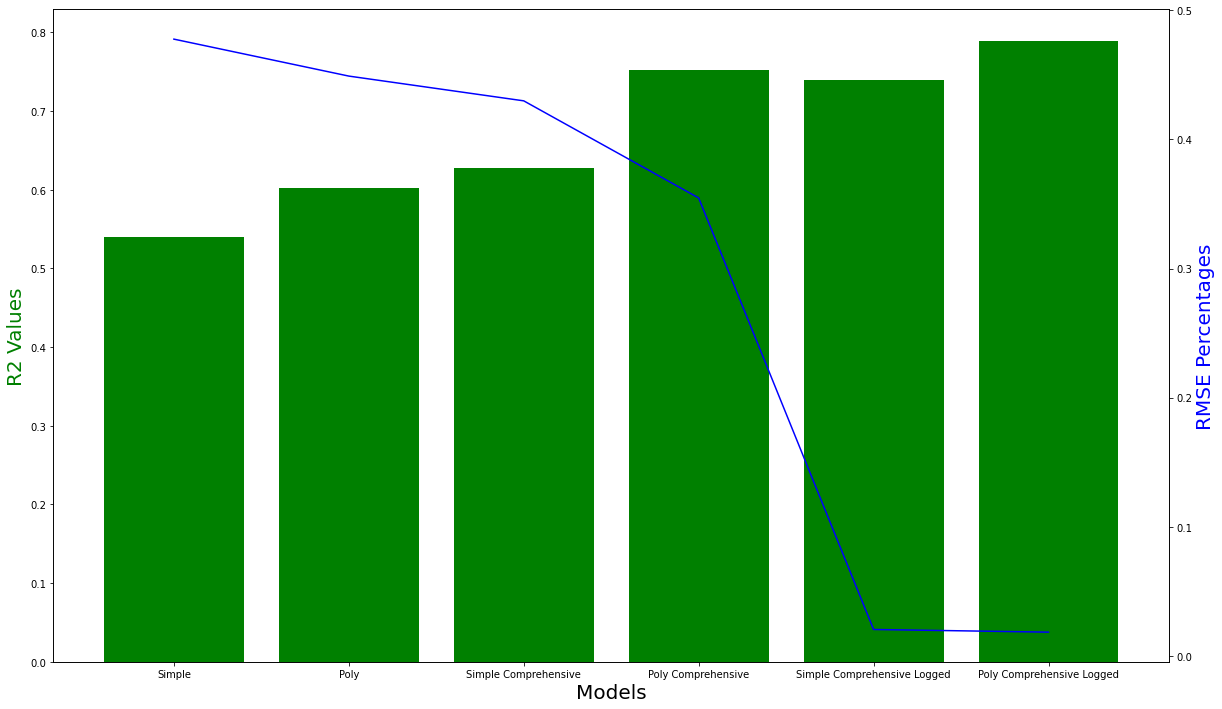

In [76]:
x = r2_model.keys()
y1 = r2_model.values()
y2 = rmse_model.values()

fig, ax1 = plt.subplots(figsize=(20, 12))

ax2 = ax1.twinx()
ax1.bar(x, y1, color = 'g')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Models', fontsize=20)
ax1.set_ylabel('R2 Values', color='g', fontsize=20)
ax2.set_ylabel('RMSE Percentages', color='b', fontsize=20)
ax1.set_xticklabels(x)

plt.show();

### Price Calculators

In [46]:
def price_calculator(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data=df):
    y = data['price_log']
    x = data[variables]
    X = sm.add_constant(x)
    model = sm.OLS(y,X).fit()
    coef = model.params
    price = coef['const'] + sqft_living*coef['sqft_living'] + grade_value*coef['grade_value'] + bedrooms*coef['bedrooms'] + sqft_above*coef['sqft_above'] + lat*coef['lat'] + long*coef['long'] +bathrooms*coef['bathrooms'] + floors*coef['floors'] + condition_num*coef['condition_num'] + age*coef['age'] + sqft_living15*coef['sqft_living15']
    return price

In [47]:
def price_calculator_zipcode(data=df):
    zipcode = int(input('What is the zipcode?\n'))
    sqft_living = int(input('How many SQFT is the house?\n'))
    grade_value = int(input('What grade is the house? From 1-Fair to 7-Excellent\n'))+4
    bedrooms = int(input('How many bedrooms does the house have?\n'))
    bathrooms = float(input('How many bathrooms does the house have?\n'))
    floors = int(input('How many floors does the house have?\n'))
    condition_num = int(input('What condition is the house in? 1-Fair to 4-Very Good\n'))
    age = int(input('How many years passed after last renovation? If never renovated put age of the house.\n '))   
    sqft_living15 = int(input('What is the average sqft of 15 closest neighbors?\n'))
    sqft_above = int(input('How many SQFT is the house excluding the basement?\n'))
    lat = int(input('What is the latitude?\n'))
    long = int(input('What is the longitude?\n'))
    
    data_zipcode = data[data['zipcode']==zipcode]
    price_area = np.exp(price_calculator(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data))
    price_zipcode = np.exp(price_calculator(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data_zipcode))
    
    if price_zipcode > (730000/1.1):
        print(f'This zipcode is too expensive for given specifications, expected price is {price_zipcode}')
    else:
        print(f'For given specifications expected price range for a house in {zipcode} zipcode would be  ${int(price_zipcode-price_zipcode*.25)} - {int(price_zipcode+price_zipcode*.25)}. ')
        print(f'For given specifications expected price range for a house in King County would be ${int(price_area-price_area*.25)} - {int(price_area+price_area*.25)}. ')
        if price_area < price_zipcode:
            print(f'This zipcode is overpriced with average ${int(price_zipcode)} compared to King County market average of ${int(price_area)}')
        elif price_area > price_zipcode:
            print(f'This zipcode is underpriced with average ${int(price_zipcode)} compared to King County market average of ${int(price_area)}')
        else:
            print('This zipcode is similar with average ${price_zipcode} compared to King County market.')

    return price_zipcode-price_zipcode*.25, price_zipcode+price_zipcode*.25

In [54]:
price_calculator_zipcode()

KeyboardInterrupt: Interrupted by user

In [55]:
def price_calculator_zipcode_log2(zipcode,sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data=df):
    
    grade_value_fixed = grade_value+4
    
    data_zipcode = data[data['zipcode']==zipcode]
    price_area = np.exp(price_calculator_partial_log(sqft_living,grade_value_fixed,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data))
    price_zipcode = np.exp(price_calculator_partial_log(sqft_living,grade_value_fixed,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data_zipcode))
    
    if price_zipcode > (730000/1.1):
        print(f'This zipcode is too expensive for given specifications, expected price is {price_zipcode}')
    else:
        print(f'For given specifications expected price range for a house in {zipcode} zipcode would be  ${int(price_zipcode-price_zipcode*.25)} - {int(price_zipcode+price_zipcode*.25)}. ')
        print(f'For given specifications expected price range for a house in King County would be ${int(price_area-price_area*.25)} - {int(price_area+price_area*.25)}. ')
        if price_area < price_zipcode:
            print(f'This zipcode is overpriced with average ${price_zipcode} compared to King County market  average of ${price_area}')
        elif price_area > price_zipcode:
            print(f'This zipcode is underpriced with average ${price_zipcode} compared to King County market  average of ${price_area}')
        else:
            print('This zipcode is similar with average ${price_zipcode} compared to King County market.')

    return price_zipcode

In [56]:
price_calculator_zipcode_log2(98023,2500,3,3,2,2,2,30,2500,2500,47,-121)

NameError: name 'price_calculator_partial_log' is not defined

In [57]:
def price_calculator_zipcode_log3(zipcode,sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data=df):
    
    grade_value_fixed = grade_value+4
    
    data_zipcode = data[data['zipcode']==zipcode]
    price_area = np.exp(price_calculator_partial_log(sqft_living,grade_value_fixed,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data))
    price_zipcode = np.exp(price_calculator_partial_log(sqft_living,grade_value_fixed,bedrooms,bathrooms,floors,condition_num,age,sqft_living15,sqft_above,lat,long,data_zipcode))

    return price_zipcode

In [58]:
price_calculator_zipcode_log(98023)

NameError: name 'price_calculator_zipcode_log' is not defined

### 3 Bedrooms

In [59]:
df3 = df[df['bedrooms'] == 3]

In [60]:
dict_3 = {}

In [61]:
dict_3['Average'] = df3['price'].mean()

In [62]:
dict_3['After_modeling'] = price_calculator_partial(df3['sqft_living'].mean(),df3['grade_value'].mean(),df3['bedrooms'].mean(),df3['bedrooms'].mean(),df3['floors'].mean(),df3['condition_num'].mean(),df3['age'].mean(),df3['sqft_living15'].mean(),df3['sqft_above'].mean(),df3['lat'].mean(),df3['long'].mean(),data=df)

NameError: name 'price_calculator_partial' is not defined

In [ ]:
dict_3['After_logging_price'] = np.exp(price_calculator_partial_log(df3['sqft_living'].mean(),df3['grade_value'].mean(),df3['bedrooms'].mean(),df3['bedrooms'].mean(),df3['floors'].mean(),df3['condition_num'].mean(),df3['age'].mean(),df3['sqft_living15'].mean(),df3['sqft_above'].mean(),df3['lat'].mean(),df3['long'].mean(),data=df))

In [ ]:
zipcodes3 = set(df3['zipcode'].value_counts().index)

In [ ]:

beginning = 9999999999
for zipcode in zipcodes3:
    price = price_calculator_zipcode_log3(zipcode,df3['sqft_living'].mean(),df3['grade_value'].mean(),df3['bedrooms'].mean(),df3['bedrooms'].mean(),df3['floors'].mean(),df3['condition_num'].mean(),df3['age'].mean(),df3['sqft_living15'].mean(),df3['sqft_above'].mean(),df3['lat'].mean(),df3['long'].mean(),data=df)
    if (price < beginning) & (price>100000):
        beginning = price
    
dict_3['After_checking_for_zipcodes'] = beginning

In [ ]:
len(zipcodes3)

In [ ]:
dict_3

### 4 Bedrooms

In [63]:
df4 = df[df['bedrooms'] == 4]

In [64]:
dict_4 = {}

In [65]:
dict_4['Average'] = df4['price'].mean()

In [66]:
dict_4['After_modeling'] = price_calculator_partial(df4['sqft_living'].mean(),df4['grade_value'].mean(),df4['bedrooms'].mean(),df4['bedrooms'].mean(),df4['floors'].mean(),df4['condition_num'].mean(),df4['age'].mean(),df4['sqft_living15'].mean(),df4['sqft_above'].mean(),df4['lat'].mean(),df4['long'].mean(),data=df)

NameError: name 'price_calculator_partial' is not defined

In [ ]:
dict_4['After_logging_price'] = np.exp(price_calculator_partial_log(df4['sqft_living'].mean(),df4['grade_value'].mean(),df4['bedrooms'].mean(),df4['bedrooms'].mean(),df4['floors'].mean(),df4['condition_num'].mean(),df4['age'].mean(),df4['sqft_living15'].mean(),df4['sqft_above'].mean(),df4['lat'].mean(),df4['long'].mean(),data=df))

In [ ]:
zipcodes4 = set(df4['zipcode'].value_counts().index)

In [ ]:

beginning = 9999999999
for zipcode in zipcodes4:
    price = price_calculator_zipcode_log3(zipcode,df4['sqft_living'].mean(),df4['grade_value'].mean(),df4['bedrooms'].mean(),df4['bedrooms'].mean(),df4['floors'].mean(),df4['condition_num'].mean(),df4['age'].mean(),df4['sqft_living15'].mean(),df4['sqft_above'].mean(),df4['lat'].mean(),df4['long'].mean(),data=df)
    if (price < beginning) & (price>100000):
        beginning = price
    
dict_4['After_checking_for_zipcodes'] = beginning

In [ ]:
df['id'].count()

In [ ]:
df

In [ ]:
z = np.array(df['zipcode'].copy())
s = np.array(df['sqft_living'].copy())
g = np.array(df['grade_value'].copy())
b = np.array(df['bedrooms'].copy())
ba = np.array(df['bathrooms'].copy())
f = np.array(df['floors'].copy())
c = np.array(df['condition_num'].copy())
a = np.array(df['age'].copy())
s15 = np.array(df['sqft_living15'].copy())
sa = np.array(df['sqft_above'].copy())
la = np.array(df['lat'].copy())
lo = np.array(df['long'].copy())
price_calc_array = price_calculator_zipcode_log3(z,s,g,b,ba,f,c,a,s15,sa,la,lo,data=df)
len(price_calc_array)

In [ ]:
df['price_calc'] = price_calc_array

In [ ]:
df['price_100k'] = df['price'].map(lambda x: x/100000)
df['price_calc_100k'] = df['price_calc'].map(lambda x: x/100000)

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['price_100k'],df['price_100k'], color='b')
ax.scatter(df['price_100k'], df['price_calc_100k'], alpha=.3)
ax.set_xlabel('Actual Prices (100k)')
ax.set_ylabel('Predicted Prices (100k)')
ax.set_title('Price Predictions vs Actual Prices')

In [ ]:
zipcodes = list(set(df['zipcode']))

In [ ]:
df3 = df3[df3['price'] < 605000]
df4 = df4[df4['price'] < 730000]

In [ ]:
price_per_zipcode_3 = {}
for i in zipcodes:
    price_per_zipcode_3[i] = price_calculator_zipcode_log3(i,df3['sqft_living'].mean(),df3['grade_value'].mean(),df3['bedrooms'].mean(),df3['bedrooms'].mean(),df3['floors'].mean(),df3['condition_num'].mean(),df3['age'].mean(),df3['sqft_living15'].mean(),df3['sqft_above'].mean(),df3['lat'].mean(),df3['long'].mean(),data=df)

In [ ]:
price_per_zipcode_3

In [ ]:
price_per_zipcode_4 = {}
for i in zipcodes:
    price_per_zipcode_4[i] = price_calculator_zipcode_log3(i,df4['sqft_living'].mean(),df4['grade_value'].mean(),df4['bedrooms'].mean(),df4['bedrooms'].mean(),df4['floors'].mean(),df4['condition_num'].mean(),df4['age'].mean(),df4['sqft_living15'].mean(),df4['sqft_above'].mean(),df4['lat'].mean(),df4['long'].mean(),data=df)

In [ ]:
pd.DataFrame(price_per_zipcode_4.values(), price_per_zipcode_4.keys())

In [67]:
target_df = df[df['grade_value'] <= 9]
target_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_value,age,condition_num,price_log
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,7,60.0,2,12.309982
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,7,24.0,2,13.195614
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0.0,98136,47.5208,-122.393,1360,5000,7,50.0,4,13.311329
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,98074,47.6168,-122.045,1800,7503,8,28.0,2,13.142166
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,0.0,98003,47.3097,-122.327,2238,6819,7,20.0,2,12.458775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0.0,98103,47.6993,-122.346,1530,1509,8,6.0,2,12.793859
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0.0,98146,47.5107,-122.362,1830,7200,8,1.0,2,12.899220
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0.0,98144,47.5944,-122.299,1020,2007,7,6.0,2,12.904459
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,0.0,98027,47.5345,-122.069,1410,1287,8,11.0,2,12.899220


In [68]:
target_df = target_df[target_df['price'] <= 730000]
target_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_value,age,condition_num,price_log
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,7,60.0,2,12.309982
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,7,24.0,2,13.195614
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0.0,98136,47.5208,-122.393,1360,5000,7,50.0,4,13.311329
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,98074,47.6168,-122.045,1800,7503,8,28.0,2,13.142166
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,0.0,98003,47.3097,-122.327,2238,6819,7,20.0,2,12.458775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0.0,98103,47.6993,-122.346,1530,1509,8,6.0,2,12.793859
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0.0,98146,47.5107,-122.362,1830,7200,8,1.0,2,12.899220
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0.0,98144,47.5944,-122.299,1020,2007,7,6.0,2,12.904459
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,0.0,98027,47.5345,-122.069,1410,1287,8,11.0,2,12.899220


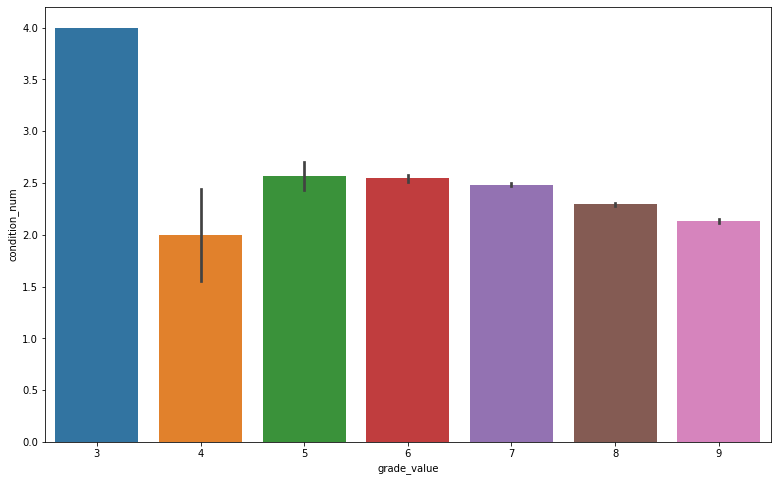

In [69]:
plt.figure(figsize=(13,8))

sns.barplot(x=target_df['grade_value'], y=target_df['condition_num'])
plt.show();

In [70]:
target_df['grade_value'].corr(target_df['condition_num'])

-0.17865551332704718

In [71]:
three_bed_homes = target_df[target_df['bedrooms'] == 3]
three_bed_homes

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_value,age,condition_num,price_log
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,7,60.0,2,12.309982
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,7,24.0,2,13.195614
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,98074,47.6168,-122.045,1800,7503,8,28.0,2,13.142166
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,0.0,98003,47.3097,-122.327,2238,6819,7,20.0,2,12.458775
7,2008000270,2015-01-15,291850.0,3,1.50,1060,9711,1.0,NO,NaN,...,0.0,98198,47.4095,-122.315,1650,9711,7,52.0,2,12.583995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,7852140040,2014-08-25,507250.0,3,2.50,2270,5536,2.0,NaN,NONE,...,0.0,98065,47.5389,-121.881,2270,5731,8,12.0,2,13.136759
21588,9834201367,2015-01-26,429000.0,3,2.00,1490,1126,3.0,NO,NONE,...,0.0,98144,47.5699,-122.288,1400,1230,8,1.0,2,12.969212
21591,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,NO,NONE,...,0.0,98116,47.5773,-122.409,1330,1265,8,7.0,2,13.071070
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0.0,98103,47.6993,-122.346,1530,1509,8,6.0,2,12.793859


In [72]:
four_bed_homes = target_df[target_df['bedrooms'] == 4]
four_bed_homes

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_value,age,condition_num,price_log
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0.0,98136,47.5208,-122.393,1360,5000,7,50.0,4,13.311329
15,9297300055,2015-01-24,650000.0,4,3.00,2950,5000,2.0,NO,GOOD,...,0.0,98126,47.5714,-122.375,2140,4000,9,36.0,2,13.384728
17,6865200140,2014-05-29,485000.0,4,1.00,1600,4300,1.5,NO,NONE,...,0.0,98103,47.6648,-122.343,1610,4300,7,99.0,3,13.091904
20,6300500875,2014-05-14,385000.0,4,1.75,1620,4980,1.0,NO,NONE,...,0.0,98133,47.7025,-122.341,1400,4980,7,68.0,3,12.860999
29,1873100390,2015-03-02,719000.0,4,2.50,2570,7173,2.0,NO,NONE,...,0.0,98052,47.7073,-122.110,2630,6026,8,10.0,2,13.485617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21561,3881900317,2015-01-23,579000.0,4,3.25,1900,2631,2.0,NO,NONE,...,0.0,98144,47.5869,-122.311,1710,4502,9,1.0,2,13.269058
21578,5087900040,2014-10-17,350000.0,4,2.75,2500,5995,2.0,NaN,NONE,...,0.0,98042,47.3749,-122.107,2530,5988,8,7.0,2,12.765688
21582,8956200760,2014-10-13,541800.0,4,2.50,3118,7866,2.0,NaN,AVERAGE,...,0.0,98001,47.2931,-122.264,2673,6500,9,1.0,2,13.202652
21589,3448900210,2014-10-14,610685.0,4,2.50,2520,6023,2.0,NO,NaN,...,0.0,98056,47.5137,-122.167,2520,6023,9,1.0,2,13.322337


In [73]:
df_3_zipcode = pd.DataFrame(price_per_zipcode_3.values(), price_per_zipcode_3.keys())
df_3_zipcode.rename(columns={0: 'Price'}, inplace = True)

df_4_zipcode = pd.DataFrame(price_per_zipcode_4.values(), price_per_zipcode_4.keys())
df_4_zipcode.rename(columns={0: 'Price'}, inplace = True)


NameError: name 'price_per_zipcode_3' is not defined

In [74]:
df_4_zipcode.sort_values('Price')

NameError: name 'df_4_zipcode' is not defined

In [ ]:
target_df['zipcode'] = target_df['zipcode'].astype('str')
# get the mean value across all data points
zipcode_data = target_df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)

In [ ]:
price_per_zipcode_4[98001]

In [ ]:
zipcode_data['Price_4'] = zipcode_data['zipcode'].astype(int).map(price_per_zipcode_4)
zipcode_data['Price_4_bedrooms'] = zipcode_data['Price_4'].map(lambda x: 730000 if x>730000 else x)
zipcode_data['Price_3'] = zipcode_data['zipcode'].astype(int).map(price_per_zipcode_4)
zipcode_data['Price_3_bedrooms'] = zipcode_data['Price_3'].astype(int).map(lambda x: 605000 if x>605000 else x)
zipcode_data['Price_4_bedrooms'].sort_values(ascending = True)

In [ ]:
# count number of houses grouped by zipcode
target_df['count'] = 1
temp = target_df.groupby('zipcode').sum()
temp.reset_index(inplace = True)
temp = temp[['zipcode', 'count']]
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')
# drop count from org dataset
target_df.drop(['count'], axis = 1, inplace = True)

In [ ]:
boundary_file = "notebooks/data/Zipcodes_for_King_County_and_Surrounding_Area__Shorelines____zipcode_shore_area.geojson"
with open(boundary_file, 'r') as f:
    geo_data = json.load(f)
    
tmp = geo_data
# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips
# save uodated JSON object
open("cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [ ]:
def map_feature_by_zipcode(zipcode_data, col):
    """
    Generates a folium map of Seattle
    :param zipcode_data: zipcode dataset
    :param col: feature to display
    :return: m
    """

    # read updated geo data
    king_geo = "cleaned_geodata.json"

    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[47.35, -121.9], zoom_start=9.25,
                   detect_retina=True, control_scale=False, tiles='OpenStreetMap')

    # Create choropleth map
    m.choropleth(
        geo_data=king_geo,
        name='choropleth',
        data=zipcode_data,
        # col: feature of interest
        columns=['zipcode', col],
        key_on='feature.properties.ZIPCODE',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='house ' + col
    )
    folium.LayerControl().add_to(m)

    # Save map based on feature of interest
    m.save(col + '.html')

    return m

In [ ]:
zipcode_data_3 = zipcode_data[zipcode_data['price'] < 605000]
zipcode_data_4 = zipcode_data[zipcode_data['price'] < 730000]



In [ ]:
map_feature_by_zipcode(zipcode_data_3, 'Price_3_bedrooms')

In [ ]:
map_feature_by_zipcode(zipcode_data_4, 'Price_4_bedrooms')

In [ ]:
df

In [ ]:
df_log = np.log(df[price_var])

In [ ]:
df_log

In [ ]:
y = df_log['price']
x = df_log[['bedrooms','bathrooms','sqft_living','floors','sqft_above','grade_value','condition_num']]
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
model.summary()

Greg's Code

target_df = df[df['grade'] <= 9]
target_df

In [ ]:
target_df = target_df[target_df['price'] <= 730000]
target_df

In [ ]:
three_bed_homes = target_df[target_df['bedrooms'] == 3]
three_bed_homes

In [ ]:
four_bed_homes = target_df[target_df['bedrooms'] == 4]
four_bed_homes

In [ ]:
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=730000)
four_bed_homes_map = folium.Map(location=[47.560093, -122.213982], zoom_start=10)

# go through each home in set, make circle, and add to map.
for i in range(len(four_bed_homes)):
    folium.Circle(
        location=[four_bed_homes.iloc[i]['lat'], four_bed_homes.iloc[i]['long']],
        radius=10,
        fill_opacity=0.05,
        fill=True,
        color=colormap(four_bed_homes.iloc[i]['price']),
    ).add_to(four_bed_homes_map)
four_bed_homes_map.add_child(colormap)
# Same as before, we save it to file
four_bed_homes_map.save('circle_map.html')

In [ ]:
four_bed_homes_map

In [ ]:
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=730000)
three_bed_homes_map = folium.Map(location=[47.560093, -122.213982], zoom_start=10)

# go through each home in set, make circle, and add to map.
for i in range(len(three_bed_homes)):
    folium.Circle(
        location=[three_bed_homes.iloc[i]['lat'], three_bed_homes.iloc[i]['long']],
        radius=10,
        fill=True,
        color=colormap(three_bed_homes.iloc[i]['price']),
        fill_opacity=0.2
    ).add_to(three_bed_homes_map)
three_bed_homes_map.add_child(colormap)
# Same as before, we save it to file
three_bed_homes_map.save('circle_map.html')

In [ ]:
three_bed_homes_map

In [ ]:
target_df['zipcode'] = target_df['zipcode'].astype('str')
# get the mean value across all data points
zipcode_data = target_df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)

In [ ]:
# count number of houses grouped by zipcode
target_df['count'] = 1
temp = target_df.groupby('zipcode').sum()
temp.reset_index(inplace = True)
temp = temp[['zipcode', 'count']]
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')
# drop count from org dataset
target_df.drop(['count'], axis = 1, inplace = True)

In [ ]:
boundary_file = "data/Zipcodes_for_King_County_and_Surrounding_Area__Shorelines____zipcode_shore_area.geojson"
with open(boundary_file, 'r') as f:
    geo_data = json.load(f)
    
tmp = geo_data
# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips
# save uodated JSON object
open("cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [ ]:
map_feature_by_zipcode(zipcode_data, 'price')